In [1]:
import matplotlib.pyplot as plt, numpy as np, pickle, os, random

In [2]:
import game as g, neuralnetworks as nn

In [3]:
results_path, experiment_no = os.getcwd()+'/Results', 1

In [4]:
with (open(os.path.join(results_path, f'{experiment_no}. Metadata.meta'), 'rb')) as open_file:
    while True:
        try:
            meta = pickle.load(open_file)
            print(f'Runs: {meta["runs"]}\nBin size: {meta["bin_size"]}')
        except EOFError:
            break
open_file.close()

Runs: 5
Bin size: 10


In [5]:
with (open(os.path.join(results_path, f'{experiment_no}. Parameters.pth'), 'rb')) as open_file:
    while True:
        try:
            parameters = pickle.load(open_file)
            print(f'Epochs: {parameters["n_epochs"]}\nReps: {parameters["n_reps_per_epoch"]}\nNetwork: {parameters["network"]}\nTrains: {parameters["n_trains"]}\nLearning Rate: {parameters["learning_rate"]}\nMin Epsilon: {parameters["min_epsilon"]}\nEpsilon Decay Factor: {parameters["epsilon_decay_factor"]}\nSGD: {parameters["use_SGD"]}')
        except EOFError:
            break
open_file.close()

Epochs: 50
Reps: 200
Network: [100, 100]
Trains: 100
Learning Rate: 0.001
Min Epsilon: 0.02
Epsilon Decay Factor: 0.92
SGD: True


In [6]:
Qnets, outputs = [], []
for i in range(meta['runs']):
    with (open(os.path.join(results_path, f'{experiment_no}. Qnet - Run {i+1}.pt'), 'rb')) as open_file:
        while True:
            try:
                Qnet = pickle.load(open_file)
                Qnets.append(Qnet)
            except EOFError:
                break
    open_file.close()
    with (open(os.path.join(results_path, f'{experiment_no}. Outputs - Run {i+1}.pth'), 'rb')) as open_file:
        while True:
            try:
                output = pickle.load(open_file)
                outputs.append(output)
            except EOFError:
                break
    open_file.close()

In [7]:
def plot_results(win_rate, bin_size):
    plt.figure(figsize=(12, 9))
    plt.gca().set(title=f'Highest win rate during training: {np.max(win_rate)}\nWin rate at training end: {win_rate[-1]}', xlabel='Epoch', ylabel='Averaged Win %', ylim=(50, 100)) # Set standard range for y
    plt.plot(range(bin_size, bin_size+len(win_rate)), win_rate)
    return

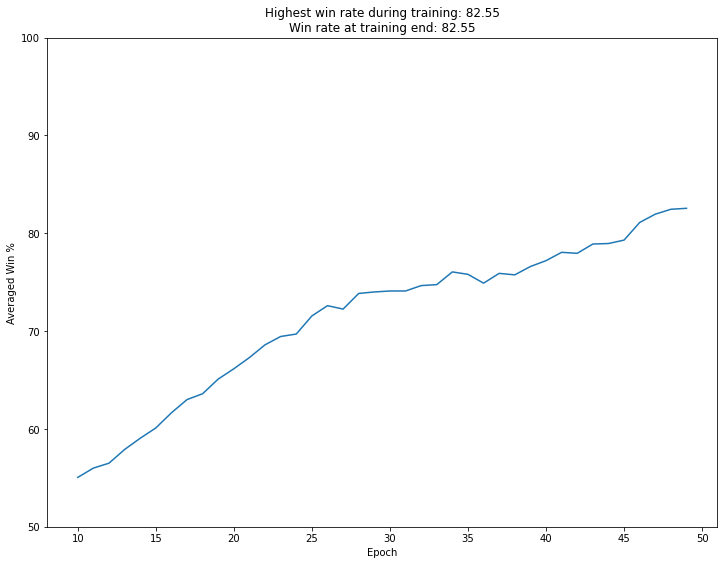

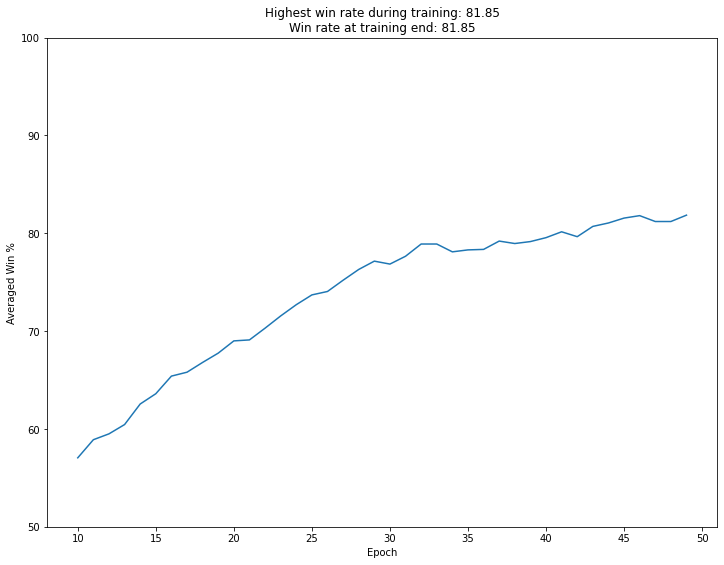

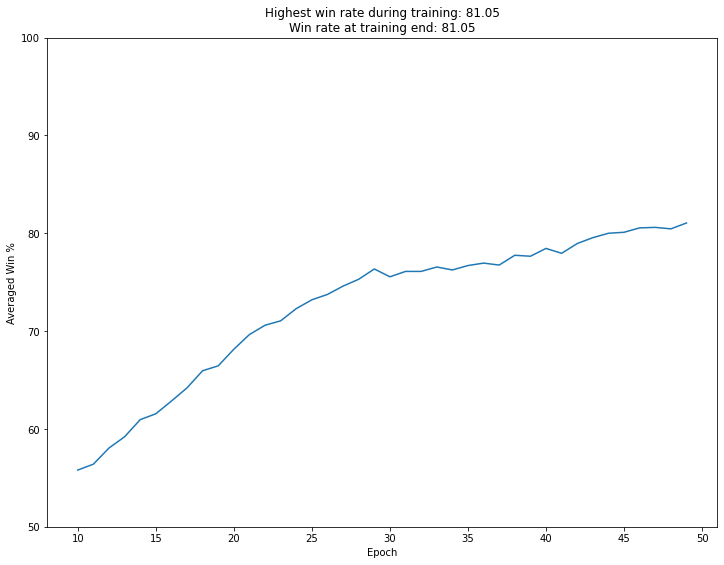

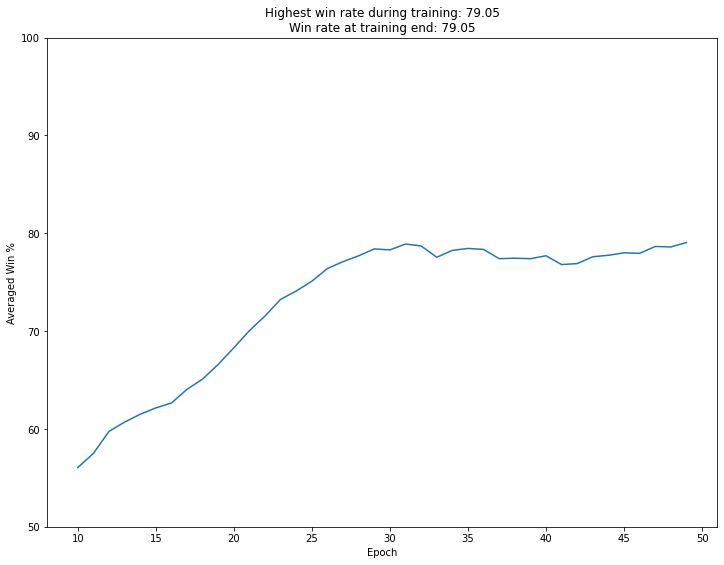

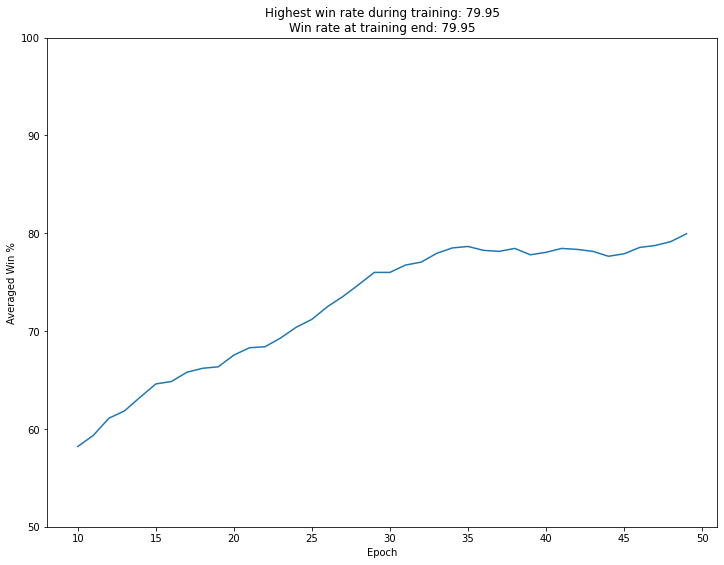

In [8]:
for output in outputs:
    plot_results(output['win_rate'], meta['bin_size'])

In [9]:
def plot_wins(win_rates, bin_size):
    plt.figure(figsize=(12, 9))
    plt.gca().set(title='Wins', xlabel='Epoch', ylabel='Win % Range', ylim=(50, 100)) # Set standard range for y
    plt.plot(range(bin_size, bin_size+win_rates.shape[1]), np.mean(win_rates, axis=0)) # Plotting win rate averaged over 5 runs
    plt.fill_between(range(bin_size, bin_size+win_rates.shape[1]), np.min(win_rates, axis=0), np.max(win_rates, axis=0), color='orange', alpha=0.3) # Plotting minimum and maximum values for individual runs
    return

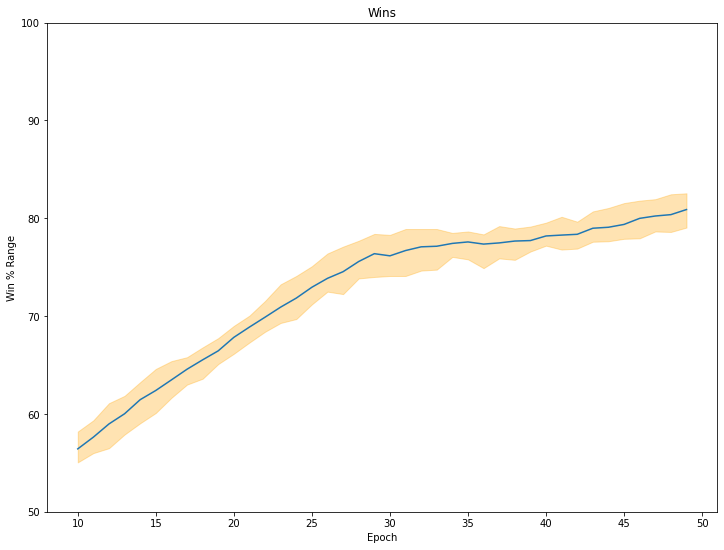

In [10]:
plot_wins(np.array([output['win_rate'] for output in outputs]).reshape(meta['runs'], -1), meta['bin_size'])

In [11]:
#Qnets[0].state_dict()

In [12]:
#print(Qnets[0].state_dict()['model.0.weight'].detach().cpu().numpy()[0])
#print(Qnets[0].state_dict()['model.0.weight'].detach().cpu().numpy()[0].shape)

In [13]:
state, turn = [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0], True
g.print_game(state)

•---•   •   •
|   |   |   |
•   •---•   •
|   |       |
•   •   •---•
|   |
•   •---•---•


In [14]:
def move_to_onehot(move):
    onehot_move = [0]*24
    onehot_move[move] = 1
    return onehot_move

def epsilon_greedy(state, valid_moves_F, Qnet, epsilon, turn):
    moves = g.valid_moves(state)
    if np.random.uniform() < epsilon: # Random move
        move = moves[random.sample(range(len(moves)), 1)[0]] # Random opponent
    else: # Greedy move
        Qs = [Qnet.use_pytorch(np.array(state + move_to_onehot(m)))[0] if Qnet.processed is True else 0 for m in moves] # Q values for deciding greedy move
        move = moves[np.argmax(Qs)] if turn else moves[random.sample(range(len(moves)), 1)[0]] # Random opponent
    Q = Qnet.use_pytorch(np.array(state + move_to_onehot(move)))[0] if Qnet.processed is True else 0
    return move, Q

In [15]:
move, _ = epsilon_greedy(state, g.valid_moves, Qnets[0], 0, turn)

In [16]:
g.print_game(g.make_move(state, move))

•---•   •   •
|   |   |   |
•   •---•   •
|   |   |   |
•   •   •---•
|   |
•   •---•---•


In [17]:
percentages, run = [], 5
for j in range(run):
    outcomes, games = [], 50
    for i in range(50):
        state, boxes, score, done = [0]*24, [0]*9, [0]*2, False
        turn = True
        move, _ = epsilon_greedy(state, g.valid_moves, Qnet, 0, turn)
        while not done:
            state_next = g.make_move(state, move)
            created, boxes = g.box_created(state_next, boxes)
            if created > 0:
                if turn:
                    score[0] += created
                else:
                    score[1] += created
            else:
                turn = not turn
            if 0 not in state_next:
                r = 1 if score[0] > score[1] else -1
                outcome, done = r, True
                move_next, Qnext = -1, 0
            else:
                move_next, Qnext = epsilon_greedy(state_next, g.valid_moves, Qnets[0], 0, turn)
            state, move = state_next, move_next
        outcomes.append(outcome)
    percentages.append(sum(outcomes[i] == 1 for i in range(len(outcomes)))/50*100)
print(sum(percentages)/run)

87.2
